<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/annual_Air_012925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -- Load county shapefiles
#dir = "/content/drive/MyDrive/Disertation/countyshp/"
#county = gpd.read_file(dir + "tl_2010_us_county00/tl_2010_us_county00.shp")
#county = county[["CNTYIDFP00", "geometry"]]

Mounted at /content/drive


In [2]:
dir = "/content/drive/MyDrive/Disertation/EPA_data/Summary/"

# -- Create pollution indicators
ind_temp = pd.DataFrame()

for year in range(1998, 2023):
  df = pd.read_csv(dir + f"annual_conc_by_monitor_{year}.csv", low_memory = False)
  #df = df[cols]
  ind_temp = pd.concat([ind_temp, df]).reset_index().drop(columns="index")

# -- Remove Canada
ind_temp = ind_temp[ind_temp["State Code"] != "CC"]
# -- Generate GEOID
ind_temp["GEOID"] = ind_temp["State Code"].astype(str).str.zfill(2) + ind_temp["County Code"].astype(str).str.zfill(3)
ind_temp["GEOID"] = ind_temp.GEOID.astype(str)

cols = ['GEOID', 'Parameter Name', "Parameter Code", "Site Num", "POC",
       'Sample Duration', 'Pollutant Standard', 'Metric Used',
       'Year', 'Units of Measure', 'Event Type', 'Observation Count',
       'Completeness Indicator', 'Valid Day Count',
       'Arithmetic Mean', 'Arithmetic Standard Dev']
ind_temp = ind_temp[cols]

# Remove cases in which events occurred
ind_temp = ind_temp[(ind_temp["Event Type"]=="No Events")|(ind_temp["Event Type"]=="Events Excluded")]
ind_temp.drop(columns=["Event Type"], inplace=True)
# Data is complete
ind_temp = ind_temp[ind_temp["Completeness Indicator"]=="Y"]
ind_temp = ind_temp.drop(columns=["Completeness Indicator"]).copy()

cols = ["GEOID", "Year", "Arithmetic Mean"]

In [3]:
# Treatmen Counties
treatments = ["18063","37179","34003","25027","13151","48329","27003","48135","42071","51107","42077","06065","34007"]

#Carbon Monoxide

In [4]:
CO = ind_temp[ind_temp["Parameter Name"]=="Carbon monoxide"]
CO = CO[CO["Metric Used"] == 'Obseved hourly values']
CO = CO[CO["Units of Measure"] == 'Parts per million']
CO = CO.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
CO = CO[cols]
CO.columns = ["GEOID", "Year", "CO"]

06065 18063 25027 27003 34003 34007 42071 42077 

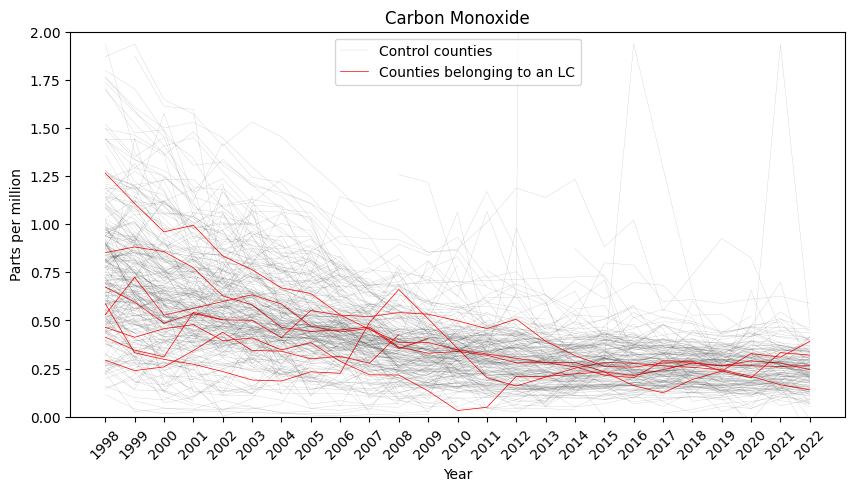

In [5]:
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in CO.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = CO[CO.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["CO"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["CO"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = CO[CO.GEOID == i]
      ax.plot(df.Year, df["CO"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = CO[CO.GEOID == i]
      ax.plot(df.Year, df["CO"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per million")
ax.set_ylim(0,2)
ax.legend()
ax.set_title("Carbon Monoxide")

fig.show()

Caption: Carbon Monoxide (CO) by County. This figure shows the yearly mean of observed hourly values of concentration of CO, in parts per million, for counties with CO monitors, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Hendricks County, IN (18063); Worcester County, MA (25027); Anoka County, MN (27003); Bergen County, NJ (34003); Camden County, NJ (34007); Lancaster County, PA (42071); Lehigh County, PA (42077). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

06065 25027 34007 

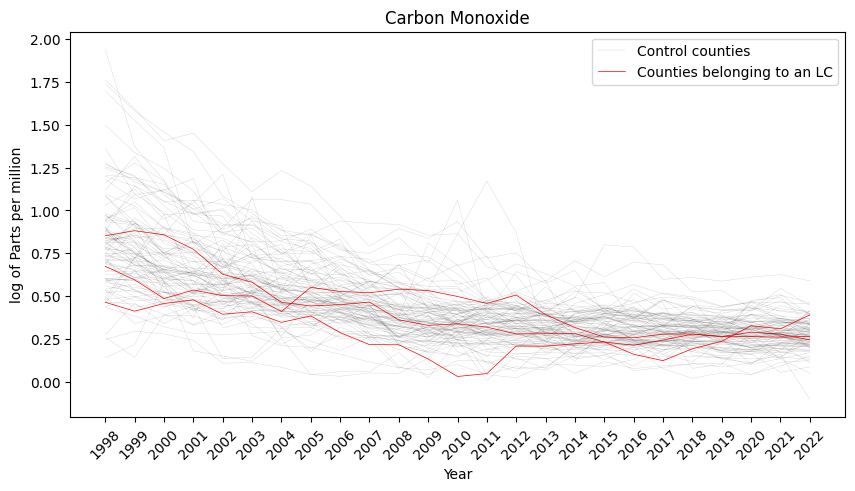

In [6]:
# Getting the GOIDS that had observations for each year
obs = CO.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
CO_mod = CO.set_index("GEOID").loc[obs["Year"] >= 25].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in CO_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = CO_mod[CO_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["CO"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["CO"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = CO_mod[CO_mod.GEOID == i]
      ax.plot(df.Year, df["CO"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = CO_mod[CO_mod.GEOID == i]
      ax.plot(df.Year, df["CO"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("log of Parts per million")

ax.legend()
ax.set_title("Carbon Monoxide")

fig.show()

Caption: Carbon Monoxide (CO) by County. This figure shows the yearly mean of observed hourly values of concentration of CO, in parts per million, for counties with CO monitors and CO concentration measures every year of the 25 years included, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Worcester County, MA (25027); Camden County, NJ (34007). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

#Ozone

In [7]:
# Ozone Units of Measure is Parts per million
O3 = ind_temp[ind_temp["Parameter Name"]=="Ozone"]
O3 = O3[O3["Units of Measure"]=="Parts per million"]
O3 = O3[O3["Metric Used"]=='Daily maximum of 8-hour running average']
O3 = O3.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
O3 = O3[cols]
O3.columns = ["GEOID", "Year", "O3"]

06065 13151 18063 25027 27003 34003 34007 37179 42071 42077 51107 

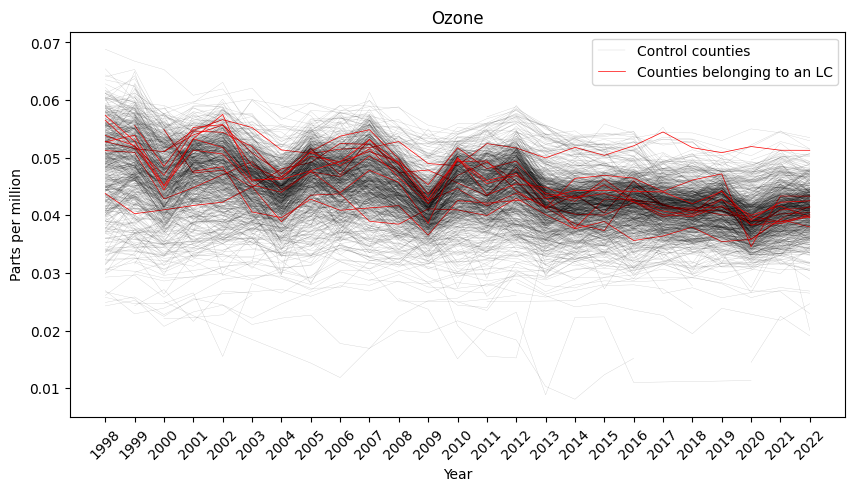

In [8]:
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in O3.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = O3[O3.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["O3"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["O3"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = O3[O3.GEOID == i]
      ax.plot(df.Year, df["O3"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = O3[O3.GEOID == i]
      ax.plot(df.Year, df["O3"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per million")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Ozone")

fig.show()

Caption: Ozone (O3) by County. This figure shows the yearly mean of daily maximum of 8-hour running average values of concentration of O3, in parts per million, for counties with O3 monitors, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Henry County, GA (13151); Hendricks County, IN (18063); Worcester County, MA (25027); Anoka County, MN (27003); Bergen County, NJ (34003); Camden County, NJ (34007); Union County, NC (37179); Lancaster County, PA (42071); Lehigh County, PA (42077); and Loudoun County, VA (51107). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

06065 27003 34007 42071 42077 

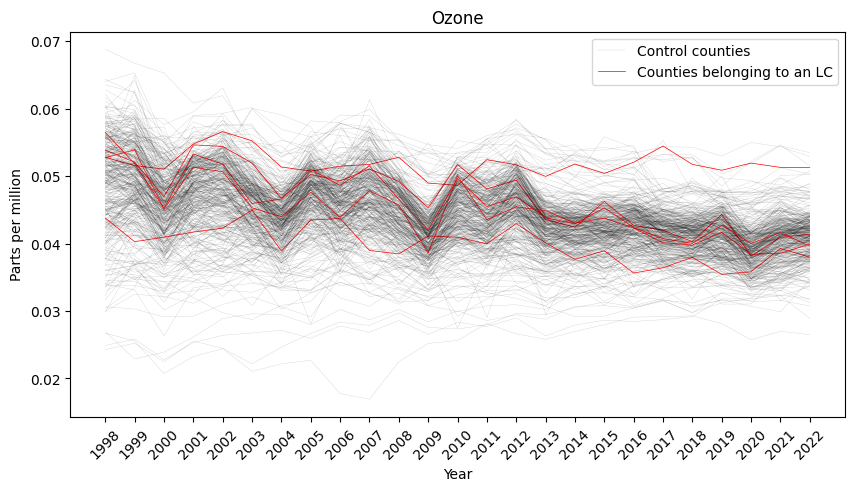

In [9]:
# Getting the GOIDS that had observations for each year
obs = O3.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
O3_mod = O3.set_index("GEOID").loc[obs["Year"] >= 25].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in O3_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = O3_mod[O3_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["O3"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["O3"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = O3_mod[O3_mod.GEOID == i]
      ax.plot(df.Year, df["O3"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = O3_mod[O3_mod.GEOID == i]
      ax.plot(df.Year, df["O3"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per million")

ax.legend()
ax.set_title("Ozone")

fig.show()

Caption: Ozone (O3) by County. This figure shows the yearly mean of daily maximum of 8-hour running average values of concentration of O3, in parts per million, for counties with O3 monitors and O3 concentration measures every year of the 25 years included, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Anoka County, MN (27003); Camden County, NJ (34007); Lancaster County, PA (42071); and Lehigh County, PA (42077). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

#Nitrogen Dioxide

In [10]:
NO2 = ind_temp[ind_temp["Parameter Name"]=="Nitrogen dioxide (NO2)"]
# NO2 is in Parts per billion
NO2 = NO2[NO2["Metric Used"]=="Observed values"]
NO2 = NO2[NO2["Units of Measure"]=="Parts per billion"]
NO2 = NO2.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
NO2 = NO2[cols]
NO2.columns = ["GEOID", "Year", "NO2"]

06065 18063 25027 27003 34003 34007 42071 42077 51107 

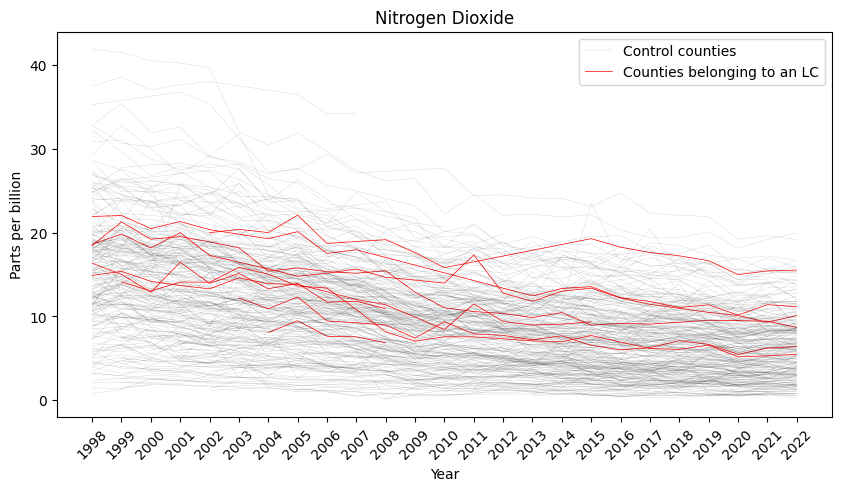

In [11]:
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in NO2.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = NO2[NO2.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["NO2"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["NO2"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = NO2[NO2.GEOID == i]
      ax.plot(df.Year, df["NO2"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = NO2[NO2.GEOID == i]
      ax.plot(df.Year, df["NO2"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per billion")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Nitrogen Dioxide")

fig.show()

Caption: Nitrogen Dioxide (NO2) by County. This figure shows the yearly mean of observed values of concentration of NO2, in parts per billion, for counties with NO2 monitors, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Worcester County, MA (25027); Camden County, NJ (34007). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

06065 25027 51107 

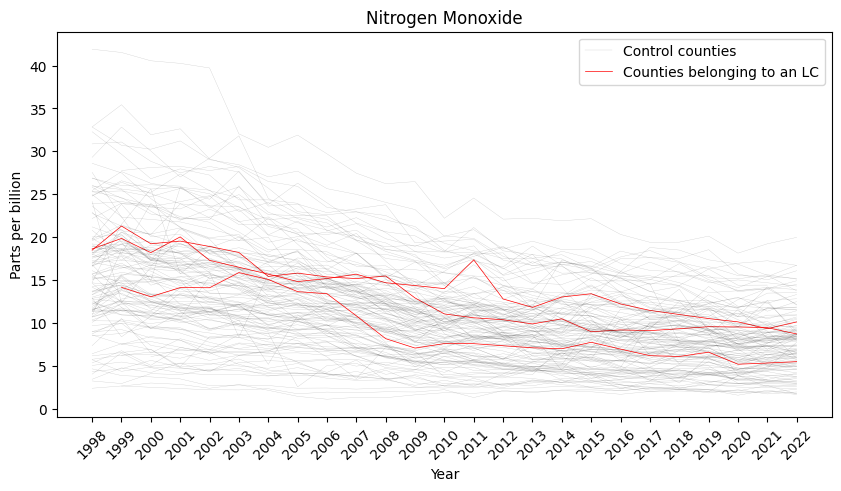

In [12]:
# Getting the GOIDS that had observations for each year
obs = NO2.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
NO2_mod = NO2.set_index("GEOID").loc[obs["Year"] >= 23].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in NO2_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = NO2_mod[NO2_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["NO2"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["NO2"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = NO2_mod[NO2_mod.GEOID == i]
      ax.plot(df.Year, df["NO2"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = NO2_mod[NO2_mod.GEOID == i]
      ax.plot(df.Year, df["NO2"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per billion")

ax.legend()
ax.set_title("Nitrogen Monoxide")

fig.show()

Caption: Nitrogen Dioxide (NO2) by County. This figure shows the yearly mean of observed values of concentration of NO2, in parts per billion, for counties with NO2 monitors and NO2 concentration measures for at least 23 out of the 25 years included, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Worcester County, MA (25027); and Lancaster County, PA (51107). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

#Sulfur Dioxide

In [13]:
SO2 = ind_temp[ind_temp["Parameter Name"]=="Sulfur dioxide"]
SO2 = SO2[SO2["Metric Used"]=="Observed Values"]
SO2 = SO2[SO2["Units of Measure"]=="Parts per billion"]
SO2 = SO2[SO2["Sample Duration"]=="1 HOUR"]
SO2 = SO2.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
SO2 = SO2[cols]
SO2.columns = ["GEOID", "Year", "SO2"]

06065 18063 25027 27003 34003 34007 42071 42077 

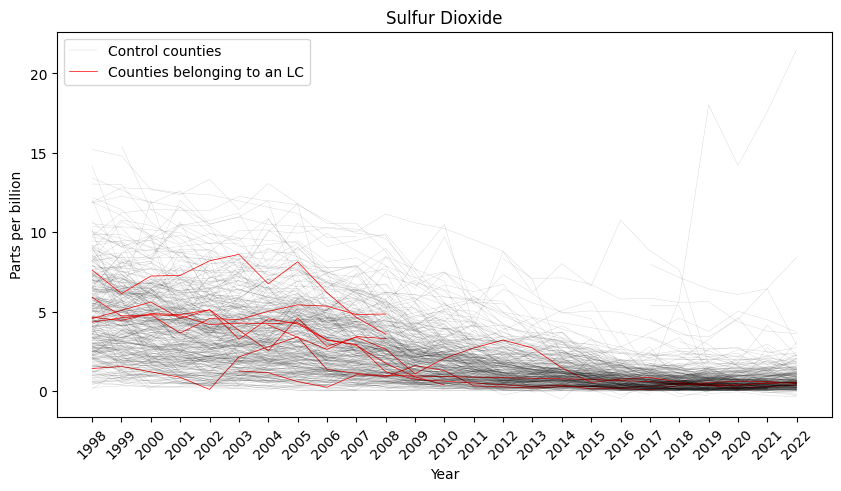

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in SO2.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = SO2[SO2.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["SO2"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["SO2"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = SO2[SO2.GEOID == i]
      ax.plot(df.Year, df["SO2"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = SO2[SO2.GEOID == i]
      ax.plot(df.Year, df["SO2"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per billion")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Sulfur Dioxide")

fig.show()

25027 34007 

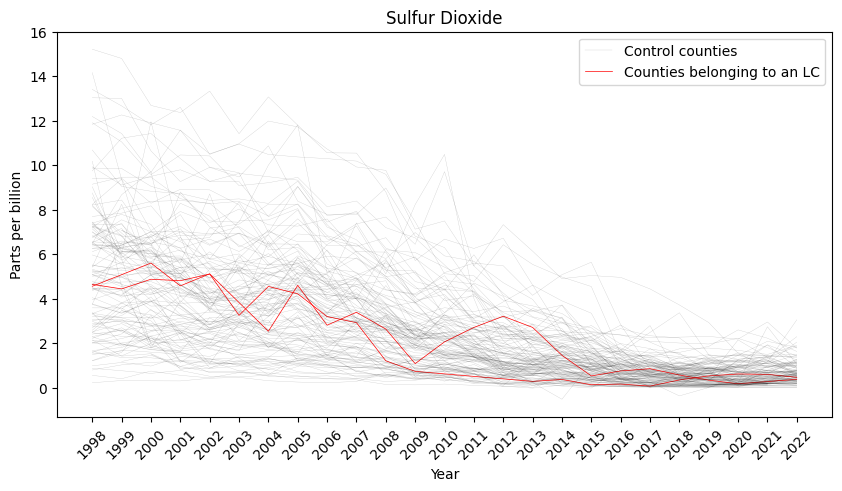

In [15]:
# Getting the GOIDS that had observations for each year
obs = SO2.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
SO2_mod = SO2.set_index("GEOID").loc[obs["Year"] >= 23].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in SO2_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = SO2_mod[SO2_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["SO2"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["SO2"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = SO2_mod[SO2_mod.GEOID == i]
      ax.plot(df.Year, df["SO2"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = SO2_mod[SO2_mod.GEOID == i]
      ax.plot(df.Year, df["SO2"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Parts per billion")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Sulfur Dioxide")
fig.show()

Caption: Sulfur Dioxide (SO2) by County. This figure shows the yearly mean of samples of one hour duration of values of concentration of SO2, in parts per billion, for counties with SO2 monitors and SO2 concentration measures for at least 23 out of the 25 years included, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Worcester County, MA (25027); and Camden County, NJ (34007). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

#PM2.5

In [16]:
PM25 = ind_temp[ind_temp["Parameter Name"]=="PM2.5 - Local Conditions"]
# Metric Used -> Daily Mean
PM25 = PM25[PM25["Metric Used"]=="Daily Mean"]
PM25 = PM25[PM25["Sample Duration"]=="24 HOUR"]
PM25 = PM25[PM25["Pollutant Standard"] == "PM25 24-hour 1997"]
PM25 = PM25[PM25["Units of Measure"] == "Micrograms/cubic meter (LC)"]
PM25 = PM25.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
PM25 = PM25[cols]
PM25.columns = ["GEOID", "Year", "PM25"]

06065 25027 27003 34003 34007 42071 42077 48135 51107 

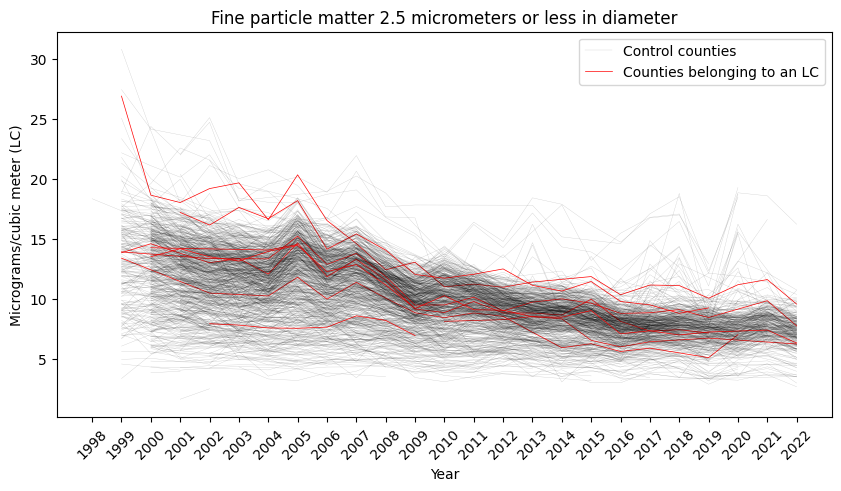

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in PM25.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = PM25[PM25.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["PM25"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["PM25"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = PM25[PM25.GEOID == i]
      ax.plot(df.Year, df["PM25"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = PM25[PM25.GEOID == i]
      ax.plot(df.Year, df["PM25"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Micrograms/cubic meter (LC)")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Fine particle matter 2.5 micrometers or less in diameter")

fig.show()

06065 34003 34007 51107 

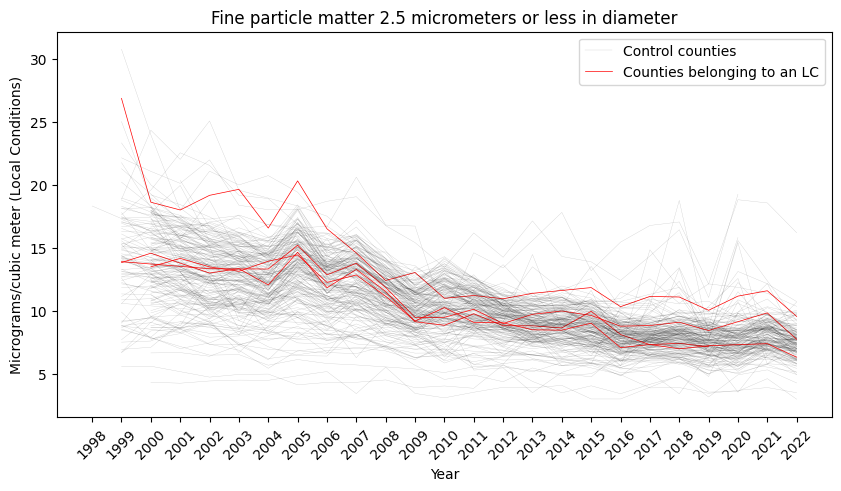

In [18]:
# Getting the GOIDS that had observations for each year
obs = PM25.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
PM25_mod = PM25.set_index("GEOID").loc[obs["Year"] >= 20].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in PM25_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = PM25_mod[PM25_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["PM25"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["PM25"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = PM25_mod[PM25_mod.GEOID == i]
      ax.plot(df.Year, df["PM25"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = PM25_mod[PM25_mod.GEOID == i]
      ax.plot(df.Year, df["PM25"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Micrograms/cubic meter (Local Conditions)")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Fine particle matter 2.5 micrometers or less in diameter")
fig.show()

Caption: Fine particle matter 2.5 micrometers or less in diameter (PM2.5) by County. This figure shows the yearly mean of daily means of 24-hour duration of values of concentration of PM2.5 at local conditions, in micrograms/cubic meter, for counties with PM2.5 monitors and PM2.5 concentration measures for at least 20 out of the 25 years included, by year. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. Possible treatment counties include: Riverside County, CA (06065); Bergen County, NJ (34003);  Camden County, NJ (34007); and Loudoun County, VA (51107). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

#PM10

In [19]:
PM10_LC = ind_temp[ind_temp["Parameter Name"]=="PM10 - LC"]
PM10_LC = PM10_LC[PM10_LC["Units of Measure"] == "Micrograms/cubic meter (LC)"]
PM10_LC = PM10_LC[PM10_LC["Sample Duration"] == "24 HOUR"]
PM10_LC = PM10_LC[PM10_LC["Metric Used"] == "Observed Values"]
PM10_LC = PM10_LC.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
PM10_LC = PM10_LC[cols]
PM10_LC.columns = ["GEOID", "Year", "PM10_LC"]

06065 25027 34003 34007 42071 

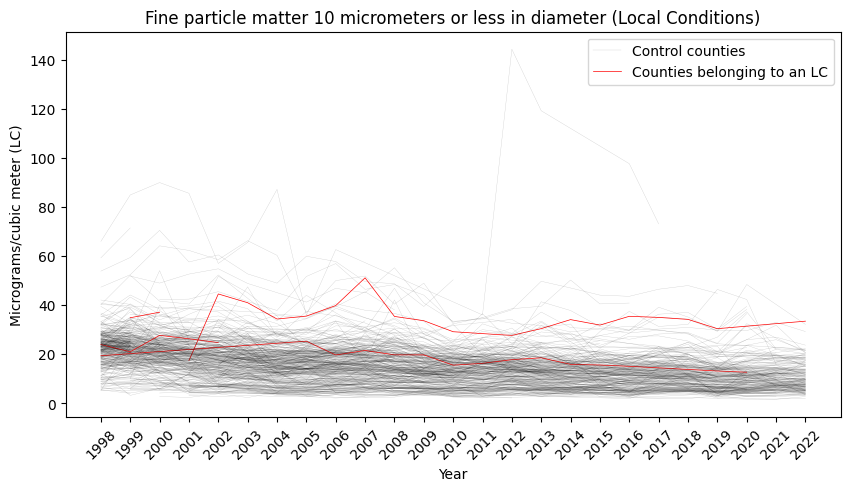

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in PM10_LC.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = PM10_LC[PM10_LC.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["PM10_LC"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["PM10_LC"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = PM10_LC[PM10_LC.GEOID == i]
      ax.plot(df.Year, df["PM10_LC"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = PM10_LC[PM10_LC.GEOID == i]
      ax.plot(df.Year, df["PM10_LC"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Micrograms/cubic meter (LC)")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Fine particle matter 10 micrometers or less in diameter (Local Conditions)")

fig.show()

06065 25027 

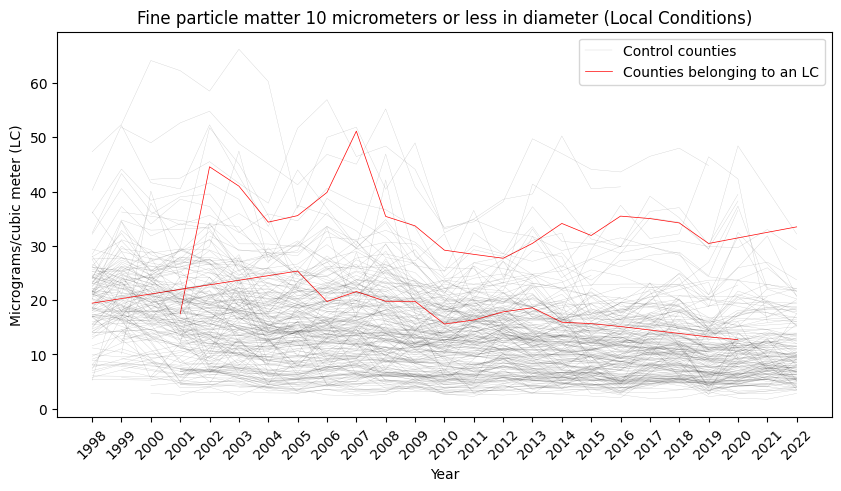

In [21]:
# Getting the GOIDS that had observations for each year
obs = PM10_LC.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
PM10_LC_mod = PM10_LC.set_index("GEOID").loc[obs["Year"] >= 15].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in PM10_LC_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = PM10_LC_mod[PM10_LC_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["PM10_LC"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["PM10_LC"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = PM10_LC_mod[PM10_LC_mod.GEOID == i]
      ax.plot(df.Year, df["PM10_LC"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = PM10_LC_mod[PM10_LC_mod.GEOID == i]
      ax.plot(df.Year, df["PM10_LC"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Micrograms/cubic meter (LC)")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Fine particle matter 10 micrometers or less in diameter (Local Conditions)")

fig.show()

In [22]:
PM10_25C = ind_temp[ind_temp["Parameter Name"]=="PM10 Total 0-10um STP"]
PM10_25C = PM10_25C[PM10_25C["Units of Measure"] == "Micrograms/cubic meter (25 C)"]
PM10_25C = PM10_25C[PM10_25C["Sample Duration"] == "24 HOUR"]
PM10_25C = PM10_25C[PM10_25C["Metric Used"] == "Daily Mean"]
PM10_25C = PM10_25C.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
PM10_25C = PM10_25C[cols]
PM10_25C.columns = ["GEOID", "Year", "PM10_25C"]

06065 18063 25027 34003 34007 

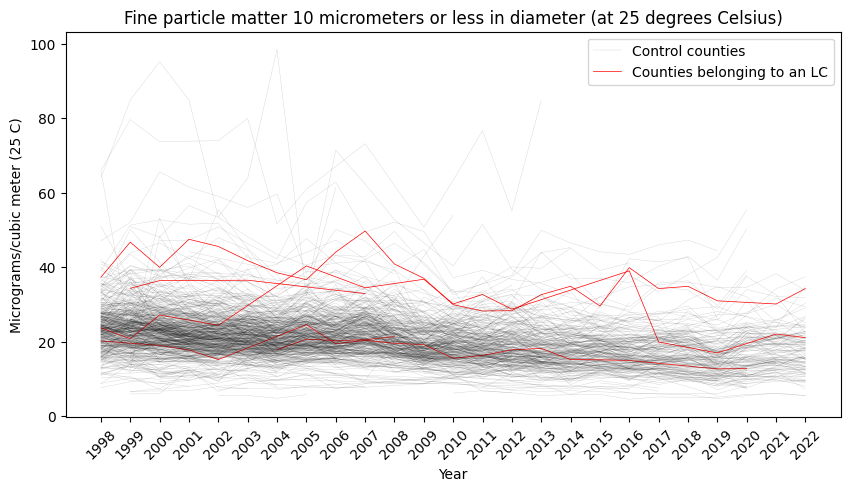

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in PM10_25C.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = PM10_25C[PM10_25C.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["PM10_25C"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["PM10_25C"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = PM10_25C[PM10_25C.GEOID == i]
      ax.plot(df.Year, df["PM10_25C"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = PM10_25C[PM10_25C.GEOID == i]
      ax.plot(df.Year, df["PM10_25C"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Micrograms/cubic meter (25 C)")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Fine particle matter 10 micrometers or less in diameter (at 25 degrees Celsius)")

fig.show()

06065 

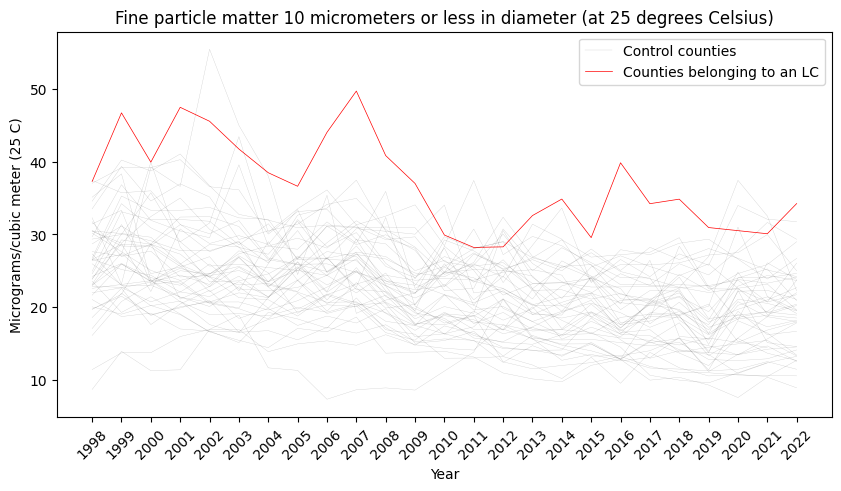

In [24]:
# Getting the GOIDS that had observations for each year
obs = PM10_25C.groupby("GEOID").count().reset_index()[["GEOID", "Year"]]
obs = obs.sort_values(by="Year", ascending=False).set_index("GEOID")
PM10_25C_mod = PM10_25C.set_index("GEOID").loc[obs["Year"] >= 24].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in PM10_25C_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = PM10_25C_mod[PM10_25C_mod.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["PM10_25C"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["PM10_25C"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = PM10_25C_mod[PM10_25C_mod.GEOID == i]
      ax.plot(df.Year, df["PM10_25C"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = PM10_25C_mod[PM10_25C_mod.GEOID == i]
      ax.plot(df.Year, df["PM10_25C"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Micrograms/cubic meter (25 C)")
#ax.set_ylim(0,2)
ax.legend()
ax.set_title("Fine particle matter 10 micrometers or less in diameter (at 25 degrees Celsius)")

fig.show()

Caption: Fine particle matter 10 micrometers or less in diameter (P10) by County. This figure shows the yearly mean of daily means of 24-hour duration samples of values of concentration of PM10 in micrograms/cubic meter, for counties with PM10 monitors and PM10 concentration measures for at least 24 out of the 25 years included, by year. The red line represents the only county that fulfills the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control. This possible treatment county is Riverside County, CA (06065). This figure was constructed using annual summary data on annual concentration by monitor, by the Environmental Protection Agency (EPA) for the specified years.

In [25]:
y = ind_temp[['GEOID','Year']]
y = y.groupby(['GEOID', 'Year']).count().reset_index()
y = y.merge(CO, on=('GEOID', 'Year'), how='left')
y = y.merge(O3, on=('GEOID', 'Year'), how='left')
y = y.merge(NO2, on=('GEOID', 'Year'), how='left')
y = y.merge(SO2, on=('GEOID', 'Year'), how='left')
y = y.merge(PM25, on=('GEOID', 'Year'), how='left')
y = y.merge(PM10_LC, on=('GEOID', 'Year'), how='left')
y = y.merge(PM10_25C, on=('GEOID', 'Year'), how='left')

In [26]:
y.describe()

,Year,CO,O3,NO2,SO2,PM25,PM10_LC,PM10_25C
count,26499.000000,5183.000000,17833.000000,5532.000000,7081.000000,10245.000000,5635.000000,6663.000000
mean,2009.980188,0.440177,0.043715,9.830897,2.420045,10.008440,16.213169,21.229545
std,7.126597,0.404442,0.005933,6.154947,2.429681,3.082627,9.364549,7.557042
min,1998.000000,-0.100685,0.008084,0.123166,-0.524266,1.617757,1.738171,4.526316
25%,2004.000000,0.246445,0.039996,5.031301,0.610984,7.775000,9.464713,16.543860
50%,2010.000000,0.369956,0.043449,8.952458,1.502636,9.542516,15.063207,20.355235
75%,2016.000000,0.553513,0.047599,13.414193,3.623258,12.053153,21.125360,24.560253
max,2022.000000,21.828902,0.068817,41.898915,21.526882,30.781928,144.185185,98.501180


In [27]:
y = ind_temp[['GEOID','Year']]
y = y.groupby(['GEOID', 'Year']).count().reset_index()
y = y.merge(CO_mod, on=('GEOID', 'Year'), how='left')
y = y.merge(O3_mod, on=('GEOID', 'Year'), how='left')
y = y.merge(NO2_mod, on=('GEOID', 'Year'), how='left')
y = y.merge(SO2_mod, on=('GEOID', 'Year'), how='left')
y = y.merge(PM25_mod, on=('GEOID', 'Year'), how='left')
y = y.merge(PM10_LC_mod, on=('GEOID', 'Year'), how='left')
y = y.merge(PM10_25C_mod, on=('GEOID', 'Year'), how='left')
y.describe()

,Year,CO,O3,NO2,SO2,PM25,PM10_LC,PM10_25C
count,26499.000000,2475.000000,9425.000000,3068.000000,2948.000000,4083.000000,3991.000000,1125.000000
mean,2009.980188,0.442695,0.043917,11.182604,2.592507,10.339210,14.852671,22.688401
std,7.126597,0.240094,0.005687,5.960466,2.529018,3.176986,8.650689,6.671884
min,1998.000000,-0.100685,0.016911,1.093029,-0.524266,2.964815,1.738171,7.363732
25%,2004.000000,0.279081,0.040299,6.779723,0.691557,8.026955,8.204696,18.070016
50%,2010.000000,0.386178,0.043532,10.364639,1.662045,9.714332,13.491525,22.433333
75%,2016.000000,0.544406,0.047623,14.637286,3.904180,12.395224,19.460130,26.696613
max,2022.000000,1.939868,0.068817,41.898915,15.217401,30.781928,66.246194,55.446174


In [28]:
y.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,26499.0,2009.980188,7.126597,1998.000000,2004.000000,2010.000000,2016.000000,2022.000000
CO,2475.0,0.442695,0.240094,-0.100685,0.279081,0.386178,0.544406,1.939868
O3,9425.0,0.043917,0.005687,0.016911,0.040299,0.043532,0.047623,0.068817
NO2,3068.0,11.182604,5.960466,1.093029,6.779723,10.364639,14.637286,41.898915
SO2,2948.0,2.592507,2.529018,-0.524266,0.691557,1.662045,3.904180,15.217401
PM25,4083.0,10.339210,3.176986,2.964815,8.026955,9.714332,12.395224,30.781928
PM10_LC,3991.0,14.852671,8.650689,1.738171,8.204696,13.491525,19.460130,66.246194
PM10_25C,1125.0,22.688401,6.671884,7.363732,18.070016,22.433333,26.696613,55.446174
